My hypotheis is that there are rides that are under a minute and are "round trips" aka ones that start and end at the same station. I believe this is true since there are times I will take a bike out and return it right away if:

1. There is something wrong with it
2. I realized I forgot something
3. It didn't actually get released from the dock and I needed to pick another one.

I want to rule these out from the dataset since they won't represent true ridership since they weren't real rides.

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
date_format = '%Y-%m-%d %H:%M:%S'
column_types = {
    'global_trip_id': 'int64',                 # this should be unique, would be good to add a check to make sure later
    'local_trip_id': 'int64', 
    'duration': 'int64',                # length of trip in minutes
    # 'start_time': 'datetime64',         # start time of trip
    # 'end_time': 'datetime64',           # end time of trip
    'start_station': 'string',           # station ID where the trip originated
    'start_lat': 'float64',             # latitude of station where trip originated
    'start_lon': 'float64',             # longitude of station where trip originated
    'end_station': 'string',             # station ID where the trip terminated
    'end_lat': 'float64',               # latitude of station where trip terminated
    'end_lon': 'float64',               # longitude of station where trip terminated
    'bike_id': 'string',                 # locally unique integer that identifies the bike
    'plan_duration': 'string',           # length of plan the passholder is using (0 = walk-up)
    'trip_route_category': 'string',  # "Round Trip" for trips starting and ending at the same station or "One Way" for all other trips (check for others)
    'passholder_type': 'string',      # "Indego30", "Indego365", "IndegoFlex", or "Walk-up"
    'bike_type': 'string',             # "electric bike" or "classic bike"
    'file_origin': 'string'           # name of file that row came from
}

In [91]:
# import the clean dataset for all years, but only return round trips
iter_csv = pd.read_csv('indego_data/trips/clean/trips_clean_2017_2023.csv', 
                       iterator = True, 
                       chunksize=100000, 
                       dtype=column_types,
                       parse_dates=['start_time', 'end_time']
                       )

df = pd.concat([chunk[
                    (chunk['start_station'] == chunk['end_station']) # round trips
                    # (chunk['duration'] <= 1440) # minutes in a day since the data dictionary says trip lengths are capped at 24
                ] 
                for chunk in iter_csv])

In [64]:
# Assuming your DataFrame is named df

mask_not_equal = df[df['start_station'] != df['end_station']]
mask_not_equal.head()


,local_trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,file_origin,global_trip_id


In [94]:
# add a new column calculated_duration which is the difference between start_time and end_time in minutes
df['calculated_duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60
df.head()

,local_trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,file_origin,global_trip_id,calculated_duration
20,365185627,1,2021-01-01 01:42:00,2021-01-01 01:43:00,3056,39.976688,-75.158127,3056,39.976688,-75.158127,17166,30,Round Trip,Indego30,electric,indego-trips-2021-q1.csv,3353,1.0
45,365191927,23,2021-01-01 06:09:00,2021-01-01 06:32:00,3067,39.964111,-75.199730,3067,39.964111,-75.199730,16665,30,Round Trip,Indego30,electric,indego-trips-2021-q1.csv,3378,23.0
48,365192027,1,2021-01-01 06:38:00,2021-01-01 06:39:00,3156,39.953812,-75.174072,3156,39.953812,-75.174072,16566,30,Round Trip,Indego30,electric,indego-trips-2021-q1.csv,3381,1.0
59,365193327,1,2021-01-01 07:34:00,2021-01-01 07:35:00,3020,39.948551,-75.190071,3020,39.948551,-75.190071,5333,30,Round Trip,Indego30,standard,indego-trips-2021-q1.csv,3392,1.0
61,365194028,21,2021-01-01 07:46:00,2021-01-01 08:07:00,3125,39.943909,-75.167351,3125,39.943909,-75.167351,19642,30,Round Trip,Indego30,electric,indego-trips-2021-q1.csv,3394,21.0


In [95]:
# check the trip lengths and inspect the ones that are calculated to be over 24 hours\
df_too_long = df[df['calculated_duration'] > 1440]
print(f"Number of trips over 24 hours: {len(df_too_long)}")

Number of trips over 24 hours: 473


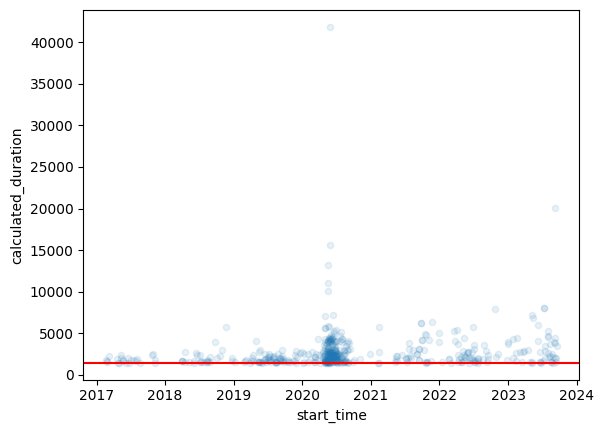

In [96]:
# scatter plot df_too_long
# x axis is start_time
# y axis is calculated_duration in minutes
# add horizontal line at 1440

df_too_long.plot.scatter(x='start_time', y='calculated_duration', alpha=0.1)
plt.axhline(y=1440, color='r', linestyle='-')

In [97]:
# create a function that prints out the top 10 most frequent values for a column and the number of times they occur
def print_top_10(df, column_name):
    top_10 = df[column_name].value_counts().head(10)
    print(f"Top 10 values for {column_name}:")
    print(top_10)
    print(f"Total number of unique values for {column_name}: {len(df[column_name].unique())}")


In [98]:
print_top_10(df, 'start_station')
print_top_10(df, 'end_station')
print_top_10(df, 'bike_id')
print_top_10(df, 'plan_duration')
print_top_10(df, 'passholder_type')
print_top_10(df, 'bike_type')

Top 10 values for start_station:
start_station
3057    22362
3212    14066
3102     8432
3202     8204
3163     7706
3049     7009
3010     6908
3054     6177
3053     5804
3028     5480
Name: count, dtype: Int64
Total number of unique values for start_station: 260
Top 10 values for end_station:
end_station
3057    22362
3212    14066
3102     8432
3202     8204
3163     7706
3049     7009
3010     6908
3054     6177
3053     5804
3028     5480
Name: count, dtype: Int64
Total number of unique values for end_station: 260
Top 10 values for bike_id:
bike_id
5353     533
11801    464
11709    453
18807    451
11043    438
11848    434
11011    426
11782    420
11872    419
11006    415
Name: count, dtype: Int64
Total number of unique values for bike_id: 4403
Top 10 values for plan_duration:
plan_duration
30     302499
1       95366
365     44474
0       21060
2         102
180        84
Name: count, dtype: Int64
Total number of unique values for plan_duration: 6
Top 10 values for passholde

There doesn't seem to be any rhyme or reason to trips being greater than 24 hours, so we are going to remove it for the purpose of the analysis of round trips. It may become relevant again in the future.

In [99]:
# remove trips that are over 24 hours
before_length = len(df)
df = df[df['calculated_duration'] <= 1440]
after_length = len(df)
print(f"Number of rows removed: {before_length - after_length}")

Number of rows removed: 473


In [100]:
# total number of round trips from each station
print(f"Number of Round Trips: {len(df):,} between {df.start_time.min().strftime('%m/%d/%Y')} and {df.end_time.max().strftime('%m/%d/%Y')}")

Number of Round Trips: 463,112 between 01/01/2017 and 10/01/2023


In [105]:
# group by start station and count and average duration and median duration
df_grouped = df.groupby('start_station').agg({'global_trip_id': 'count', 'calculated_duration': 'mean', 'calculated_duration': 'median'})

# join with df to get the start lat and lon
df_grouped = df_grouped.join(df[['start_station', 'start_lat', 'start_lon']].drop_duplicates().set_index('start_station'))

# remove any outlier lat and longs that arent within the city limits of philadelphia
df_grouped = df_grouped[df_grouped['start_lat'] > 39]
df_grouped = df_grouped[df_grouped['start_lat'] < 40]
df_grouped = df_grouped[df_grouped['start_lon'] > -76]
df_grouped = df_grouped[df_grouped['start_lon'] < -75]

In [113]:
# plot df_grouped as a scatter plot
# x axis is start longitude
# y axis is start latitude
# size of dot is number of round trips

# plot with map in background using folium
import folium
from folium.plugins import HeatMap

# create map
m = folium.Map(location=[39.9526, -75.1652], zoom_start=12)

# add heat map
HeatMap(data=df_grouped[['start_lat', 'start_lon', 'global_trip_id']].groupby(['start_lat', 'start_lon']).sum().reset_index().values.tolist(), radius=24, max_zoom=13).add_to(m)

# add markers
# for index, row in df_grouped.iterrows():
#     folium.CircleMarker([row['start_lat'], row['start_lon']], radius=row['global_trip_id']/1000, popup=f"{index}: {row['global_trip_id']}", color='blue', fill=True, fill_color='blue').add_to(m)

# save map
m.save('map.html')


# df_grouped.plot.scatter(x='start_lon', y='start_lat', s=df_grouped['global_trip_id']/1000, alpha=0.5)

: 

It appears that most round trips occur around the art museum, center city, and right around the west side of Drexel in University City. This is not surprising. People likely take bikes from the Art Museum to ride up and down the Schukyll River Trail.
![image](artifacts/round%20trip%20heatmap.png)

In [67]:
# print max, min, and average trip duration
print(f"Max Trip Duration: {df.duration.max():,} minutes")
print(f"Min Trip Duration: {df.duration.min():,} minutes")
print(f"Average Trip Duration: {df.duration.mean():,.2f} minutes")

print(f"Max Trip Duration: {df.calculated_duration.max():,} minutes")
print(f"Min Trip Duration: {df.calculated_duration.min():,} minutes")
print(f"Average Trip Duration: {df.calculated_duration.mean():,.2f} minutes")

Max Trip Duration: 1,440 minutes
Min Trip Duration: 1 minutes
Average Trip Duration: 40.10 minutes
Max Trip Duration: 41,867.0 minutes
Min Trip Duration: -4.0 minutes
Average Trip Duration: 38.53 minutes


In [68]:
df['month_year'] = df['start_time'].dt.to_period('M')

In [72]:
grouped_data = df.groupby('month_year')['duration'].agg(['max', 'min', 'mean', 'count'])
grouped_data_calculated = df.groupby('month_year')['calculated_duration'].agg(['max', 'min', 'mean', 'count'])

grouped_data.head()


,max,min,mean,count
month_year,,,,
2017-01,1440,60,513.625498,753
2017-02,1440,60,497.441204,1063
2017-03,1440,60,492.593407,910
2017-04,1440,1,49.495454,5169
2017-05,1440,1,43.512996,4963


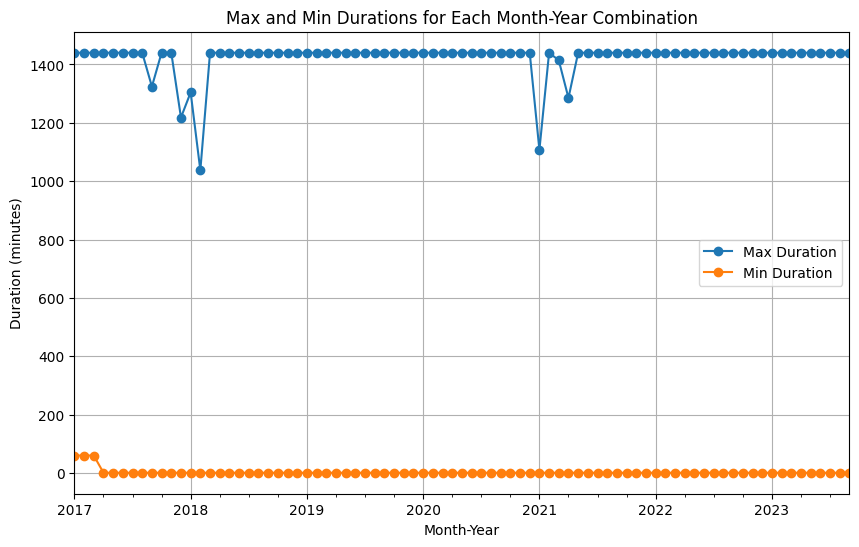

In [71]:
plt.figure(figsize=(10, 6))
grouped_data['max'].plot(label='Max Duration', marker='o')
grouped_data['min'].plot(label='Min Duration', marker='o')
plt.title('Max and Min Durations for Each Month-Year Combination')
plt.xlabel('Month-Year')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.grid(True)
plt.show()

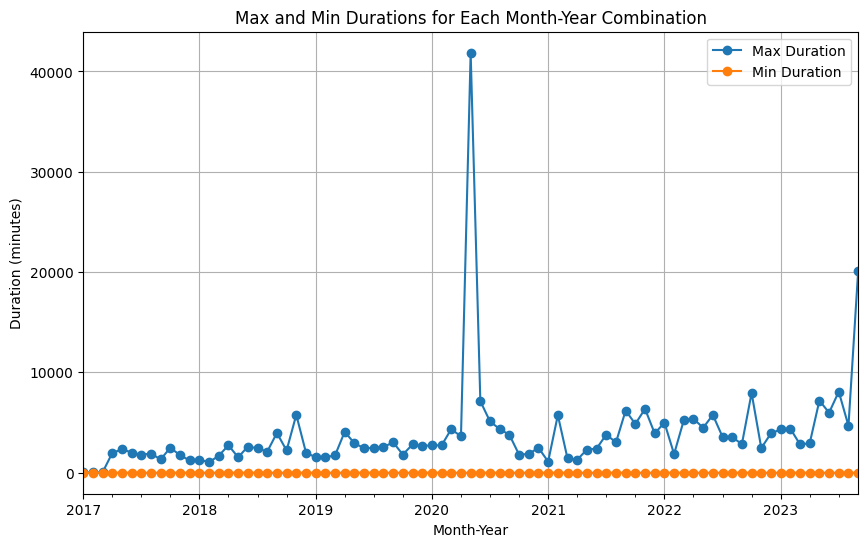

In [73]:
plt.figure(figsize=(10, 6))
grouped_data_calculated['max'].plot(label='Max Duration', marker='o')
grouped_data_calculated['min'].plot(label='Min Duration', marker='o')
plt.title('Max and Min Durations for Each Month-Year Combination')
plt.xlabel('Month-Year')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# create new dataframe from df grouped by month/year and count of trips, max calculated_duration, min calculated_duration, and average calculated_duration

df_monthly = df.groupby([df.start_time.dt.year.rename('year'), df.start_time.dt.month.rename('month')]).agg({'global_trip_id': 'count', 'calculated_duration': ['max', 'min', 'mean']})


KeyError: 'month'

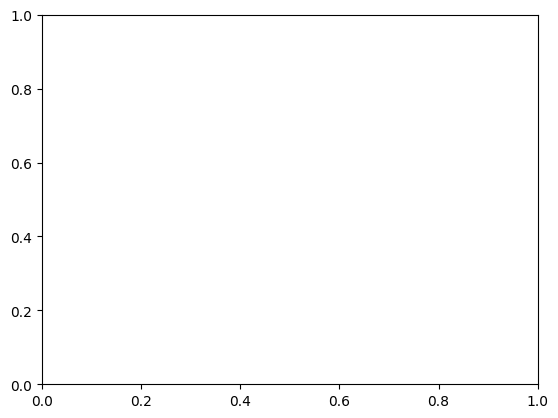

In [58]:
# scatterplot from df_monthly of max and min calculated_duration
# x axis is month and year
# y axis is calculated_duration

df_monthly.plot.scatter(x='month', y='calculated_duration', c='DarkBlue')